Train set: 25000 ejemplos
Test  set: 25000 ejemplos



text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

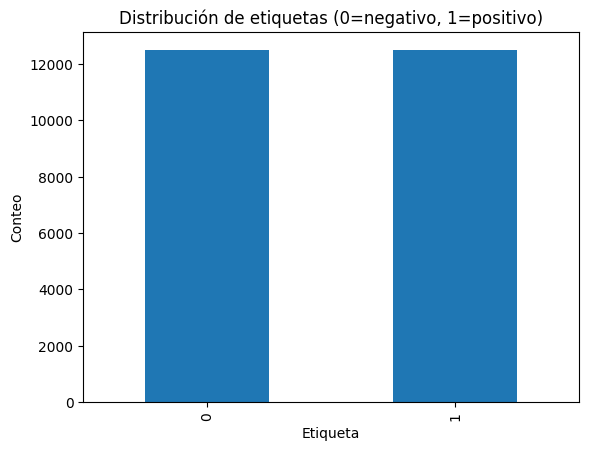

count    25000.00000
mean      1325.06964
std       1003.13367
min         52.00000
25%        702.00000
50%        979.00000
75%       1614.00000
max      13704.00000
Name: length, dtype: float64

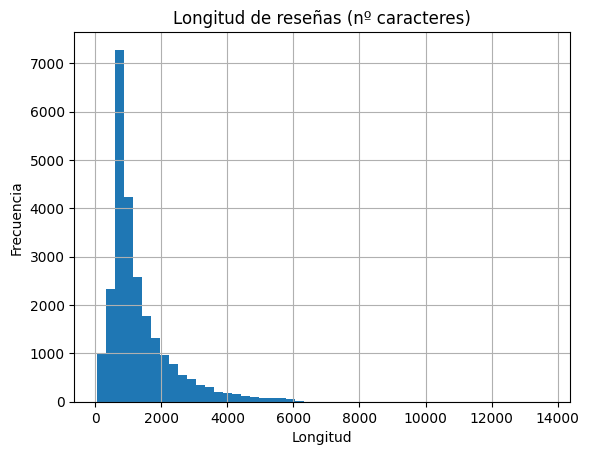

palabra  conteo
0      the  336749
1      and  164140
2        a  163123
3       of  145864
4       to  135724
5       is  107332
6       br  101871
7       it   96467
8       in   93976
9        i   87690
10    this   76007
11    that   73286
12       s   63602
13     was   48209
14      as   46935
15     for   44345
16    with   44130
17   movie   44047
18     but   42623
19    film   40159

In [1]:
# ---------------------------------------------
# CELDA 1: IMPORTACIONES Y CARGA DE DATOS (EDA)
# ---------------------------------------------

# 1) Librerías de datos y visualización
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")   # Ocultar warnings no críticos

# 2) Carga del dataset IMDb
ds = load_dataset("imdb")           # Descarga y cachea automáticamente
train = ds["train"].to_pandas()     # Partición de entrenamiento
test  = ds["test"].to_pandas()      # Partición de prueba

# 3) Vistazo rápido a los datos
print(f"Train set: {train.shape[0]} ejemplos")
print(f"Test  set: {test.shape[0]} ejemplos\n")
display(train.head())

# 4) Distribución de clases
train["label"].value_counts().plot.bar()
plt.title("Distribución de etiquetas (0=negativo, 1=positivo)")
plt.xlabel("Etiqueta")
plt.ylabel("Conteo")
plt.show()

# 5) Análisis de longitud de reseñas
train["length"] = train["text"].str.len()
display(train["length"].describe())  # Media, percentiles, etc.
train["length"].hist(bins=50)
plt.title("Longitud de reseñas (nº caracteres)")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.show()

# 6) Top 20 palabras más frecuentes
all_words = Counter()
for t in train["text"]:
    tokens = re.findall(r"\w+", t.lower())  # Solo palabras
    all_words.update(tokens)
most_common = all_words.most_common(20)
display(pd.DataFrame(most_common, columns=["palabra","conteo"]))


In [2]:
# -------------------------------------------------------------
# CELDA 2: TOKENIZACIÓN Y CREACIÓN DE DATASETS & DATALOADERS
# -------------------------------------------------------------

# 1) Importaciones necesarias
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# 2) Cargar tokenizer BERT
#    - "bert-base-uncased" es un modelo preentrenado en inglés
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print("Tokenizer cargado:", tokenizer.__class__.__name__)

# 3) Definir clase Dataset para IMDb
class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        # Tokenización y padding/truncation
        enc = self.tokenizer(
            text,
            add_special_tokens=True,      # Añade [CLS] y [SEP]
            max_length=self.max_len,      # Longitud fija
            truncation=True,              # Trunca si es muy largo
            padding="max_length",         # Rellena si es muy corto
            return_attention_mask=True,   # Máscara de atención
            return_tensors="pt"           # Tensores PyTorch
        )
        return {
            "input_ids":      enc["input_ids"].squeeze(),      # Tensor [max_len]
            "attention_mask": enc["attention_mask"].squeeze(), # Tensor [max_len]
            "labels":         torch.tensor(label, dtype=torch.long)
        }

# 4) Instanciar los datasets de entrenamiento y prueba
train_dataset = IMDbDataset(
    texts=train["text"].tolist(),
    labels=train["label"].tolist(),
    tokenizer=tokenizer,
    max_len=128
)
test_dataset = IMDbDataset(
    texts=test["text"].tolist(),
    labels=test["label"].tolist(),
    tokenizer=tokenizer,
    max_len=128
)

# 5) Crear DataLoaders para batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# 6) Verificar número de batches y un batch de ejemplo
print(f"Batches de entrenamiento: {len(train_loader)}")
print(f"Batches de validación:   {len(test_loader)}\n")

# Obtener y mostrar dimensiones de un batch
batch = next(iter(train_loader))
print("Tamaños del batch de entrenamiento:")
print("  input_ids     ", batch["input_ids"].shape)
print("  attention_mask", batch["attention_mask"].shape)
print("  labels        ", batch["labels"].shape)


Tokenizer cargado: BertTokenizerFast
Batches de entrenamiento: 1563
Batches de validación:   1563

Tamaños del batch de entrenamiento:
  input_ids      torch.Size([16, 128])
  attention_mask torch.Size([16, 128])
  labels         torch.Size([16])


In [3]:
# -------------------------------------------------------------
# CELDA 3: DEFINICIÓN, ENTRENAMIENTO, EVALUACIÓN Y GUARDADO
# -------------------------------------------------------------

# 1) Importaciones para el entrenamiento
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# 2) Carga del modelo BERT para clasificación binaria
#    num_labels=2 porque tenemos dos clases: positiva y negativa
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

# 3) Definición de la función de métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1":       f1_score(labels, preds)
    }

# 4) Configuración de los argumentos de entrenamiento
#    Adaptado a transformers 4.51.3 con do_train y do_eval
training_args = TrainingArguments(
    output_dir="./results",            # Carpeta donde guardar checkpoints
    num_train_epochs=3,                # Número de pasadas sobre el dataset
    per_device_train_batch_size=16,    # Tamaño de batch en entrenamiento
    per_device_eval_batch_size=16,     # Tamaño de batch en evaluación
    do_train=True,                     # Ejecutar fase de entrenamiento
    do_eval=True,                      # Ejecutar evaluación al final
    logging_dir="./logs",              # Carpeta de logs para TensorBoard
    logging_steps=100                  # Cada cuántos pasos registrar métricas
)

print("✔ TrainingArguments configurados")

# 5) Creación del Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,      # Viene de la celda 2
    eval_dataset=test_dataset,        # Viene de la celda 2
    compute_metrics=compute_metrics
)

print("✔ Trainer instanciado")

# 6) Lanzar el entrenamiento
print("\n→ Entrenamiento en curso… puede tardar varios minutos:")
trainer.train()

# 7) Evaluación final en test set
metrics = trainer.evaluate()
print("\n✔ Evaluación final en test:")
for name, value in metrics.items():
    print(f"  {name}: {value:.4f}")

# 8) Guardar modelo y tokenizer para despliegue
trainer.save_model("sentiment-bert-model")        # Pesos y config
tokenizer.save_pretrained("sentiment-bert-model") # Archivos del tokenizer
print("\n✔ Modelo y tokenizer guardados en 'sentiment-bert-model/'")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✔ TrainingArguments configurados
✔ Trainer instanciado

→ Entrenamiento en curso… puede tardar varios minutos:



✔ Evaluación final en test:
  eval_loss: 0.5139
  eval_accuracy: 0.8884
  eval_f1: 0.8883
  eval_runtime: 7263.0685
  eval_samples_per_second: 3.4420
  eval_steps_per_second: 0.2150
  epoch: 3.0000

✔ Modelo y tokenizer guardados en 'sentiment-bert-model/'
